# SIL 761 Project: Siamese Networks for deforestation detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps  
import os  

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, npDataset2019, npDataset2020, labels):
        self.np19 = npDataset2019.astype(np.float32)
        self.np20 = npDataset2020.astype(np.float32)
        self.labels = np.hstack((labels, 1-labels)).astype(np.float32)
        


    def __getitem__(self,index):
        
        return torch.from_numpy(self.np19[index]), torch.from_numpy(self.np20[index]), torch.from_numpy(self.labels[index])
    
    def __len__(self):
        return (self.labels.shape[0])

Importing data

In [ ]:
folder_path = "/content/drive/MyDrive/"

In [ ]:
from os import replace
from unittest.mock import patch
from osgeo import gdal
import numpy as np
import pickle
from random import sample
import sys

def get_array(filename):
    ds = gdal.Open(filename)
    img_array = np.zeros((ds.RasterCount, ds.RasterYSize, ds.RasterXSize))

    for i in range(ds.RasterCount):
        img_array[i,:,:] = np.array(ds.GetRasterBand(i+1).ReadAsArray())/ (20000 if i < 7 else 1) 
    # print(img_array.shape)
    return img_array

In [ ]:


def make_patches(arr_2019, arr_2020, arr_deforestation, size=15, stride=3, threshhold = 0.5, sampling=False):
    #initialize constants and arrays
    bands, ysize, xsize = arr_2019.shape[0], arr_2019.shape[1], arr_2019.shape[2]
    ypatches = int((ysize-size+stride)//stride)
    xpatches = int((xsize-size+stride)//stride)
    patches_2019 = np.zeros((xpatches*ypatches, bands, size, size))
    patches_2020 = np.zeros((xpatches*ypatches, bands, size, size))
    labels = np.zeros((xpatches*ypatches, 1))
    nan_mask = np.ones(xpatches*ypatches, dtype=bool)
    #read data
    for i in range(0, ysize-size+1, stride):
        for j in range(0, xsize-size+1, stride):
            patches_2019[(i*xpatches+j)//stride] = arr_2019[:, i:i+size, j:j+size]
            patches_2020[(i*xpatches+j)//stride] = arr_2020[:, i:i+size, j:j+size]
            labels[(i*xpatches+j)//stride, 0] = 1 if (np.count_nonzero(arr_deforestation[0, i:i+size, j:j+size])/size**2) > threshhold else 0
            nan_mask[(i*xpatches+j)//stride] = not (np.any(np.isnan(arr_2019[:, i:i+size, j:j+size])) or \
                                                np.any(np.isnan(arr_2020[:, i:i+size, j:j+size])))
   
    patches_2019 = patches_2019[nan_mask]
    patches_2020 = patches_2020[nan_mask]
    labels = labels[nan_mask]
    #augment, downsample for train
    if sampling:
        true_indices = np.nonzero(labels)[0]
        false_indices = np.nonzero(1-labels)[0]

        patches_2019_true = patches_2019[true_indices, :, :, :]
        patches_2019_true = np.vstack((patches_2019_true, 
                                        patches_2019_true[:, :, ::-1, :], 
                                        patches_2019_true[:, :, :, ::-1],
                                        patches_2019_true[:, :, ::-1, ::-1]))
        patches_2019_false = patches_2019[false_indices, :, :, :]
        if 5*patches_2019_true.shape[0] > patches_2019_false.shape[0]:
            random_undersample = np.arange(patches_2019_false.shape[0])
        else:
            random_undersample = np.random.choice(patches_2019_false.shape[0], 5*patches_2019_true.shape[0], replace=False)
        patches_2019_false = patches_2019_false[random_undersample, :, :, :]
        patches_2019 = np.vstack((patches_2019_true, patches_2019_false))

        patches_2020_true = patches_2020[true_indices, :, :, :]
        patches_2020_true = np.vstack((patches_2020_true, 
                                        patches_2020_true[:, :, ::-1, :], 
                                        patches_2020_true[:, :, :, ::-1],
                                        patches_2020_true[:, :, ::-1, ::-1]))
        patches_2020_false = patches_2020[false_indices, :, :, :]
        patches_2020_false = patches_2020_false[random_undersample, :, :, :]
        patches_2020 = np.vstack((patches_2020_true, patches_2020_false))

        labels = np.vstack((np.ones((patches_2020_true.shape[0], 1)), 
                            np.zeros((patches_2020_false.shape[0], 1))))
    else:
        #possible downsample for test, val
        pass

    return patches_2019, patches_2020, labels

def create_set_from_list(tiles, train=False, path=folder_path):
    ret = [[], [], []]
    for i in tiles:
        y = int(300*(i//6))
        x = int(300*(i%6))
        arr_2019 = get_array(path + f"tiles/tile_2019_{x}_{y}.tif")
        arr_2020 = get_array(path + f"tiles/tile_2020_{x}_{y}.tif")
        arr_deforestation = get_array(path + f"tiles/deforestation_{x}_{y}.tif")
        patches_2019, patches_2020, labels = make_patches(arr_2019, arr_2020, arr_deforestation, sampling=train)
        # if (np.count_nonzero(np.))
        ret[0].append(patches_2019)
        ret[1].append(patches_2020)
        ret[2].append(labels)
    
    ret[0] = np.vstack(ret[0])
    ret[1] = np.vstack(ret[1])
    ret[2] = np.vstack(ret[2])
    
    perm = np.random.permutation(ret[0].shape[0])
    ret[0] = ret[0][perm]
    ret[1] = ret[1][perm]
    ret[2] = ret[2][perm]
    return ret


def create_train_test_split():

    all = [i for i in range(24)]
    train = sample(all, 10)
    all = [i for i in all if i not in train]
    val = sample(all, 1)
    # all = [i for i in all if i not in val]
    # test = sample(all, 5)

    #return train, val and test tuples containing (2019_patches, 2020_patches, labels)
    return create_set_from_list(train, True), create_set_from_list(val), [] # create_set_from_list(test)

train, val, test = create_train_test_split()
with open('data.pkl', 'wb') as f:
    pickle.dump({"train":train, "val":val, "test":test}, f)

In [ ]:
import pickle
with open("data.pkl", 'rb') as f:
  dic = pickle.load(f)


In [ ]:
dic.keys()

dict_keys(['train', 'val', 'test'])

In [ ]:
dic['train'][0].shape, dic['train'][1].shape, dic['train'][2].shape

((52458, 11, 15, 15), (52458, 11, 15, 15), (52458, 1))

In [ ]:
np.count_nonzero(np.isnan(dic['train'][0])), np.count_nonzero(np.isnan(dic['train'][1])), np.count_nonzero(np.isnan(dic['train'][2]))

(0, 0, 0)

In [ ]:
np.max(dic['train'][0]), np.max(dic['train'][1]), np.max(dic['train'][2])

(0.9517286366601435, 0.9979354838709678, 1.0)

In [ ]:
np.min(dic['train'][0]), np.min(dic['train'][1]), np.min(dic['train'][2])

(-0.7277179236043095, -0.9067750677506775, 0.0)

In [ ]:
# # Resize the images and transform to tensors
# transformation = transforms.Compose([transforms.Resize((100,100)),
#                                      transforms.ToTensor()
#                                     ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(dic['train'][0], dic['train'][1], dic['train'][2])
val_dataset = SiameseNetworkDataset(dic['val'][0], dic['val'][1], dic['val'][2])
# test_dataset = SiameseNetworkDataset(dic['test'][0], dic['test'][1], dic['test'][2])

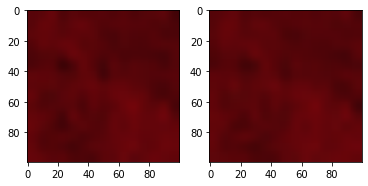

In [ ]:
from random import randint
from PIL import Image
x = np.random.choice(np.nonzero(1-dic['train'][2])[0])

fig, ax = plt.subplots(1,2)
ax[0].imshow(Image.fromarray(np.rollaxis((dic['train'][0][x, [4, 3, 2], :, :]*2*255).astype(np.uint8), 0,3)).resize((100,100)))
ax[1].imshow(Image.fromarray(np.rollaxis((dic['train'][1][x, [4, 3, 2], :, :]*2*255).astype(np.uint8), 0,3)).resize((100,100)))


In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(11, 128, kernel_size=3,stride=1,padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3,stride=1, padding='same'),
            nn.ReLU(inplace=True)
        )


        # Setting up the Fully Connected Layers
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.2),
            # nn.ReLU(inplace=True),
            
            # nn.Linear(4096, 1024),
            # nn.ReLU(inplace=True),

            # nn.Linear(1024, 256),
            # nn.ReLU(inplace=True),
            
            nn.Linear(9216,2),
            nn.Softmax()
        )
        
    def forward(self, input1, input2):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)

        
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        # print(output1.size(), output2.size())

        output3 = torch.cat((output1, output2), dim=1)

        
        # print(output.size())
        output = self.fc2(output3)
        return output

    # def forward(self, input1, input2):
    #     # In this function we pass in both images and obtain both vectors
    #     # which are returned
    #     output1 = self.forward_once(input1)
    #     output2 = self.forward_once(input2)

    #     return output1, output2

In [ ]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=64)

val_dataloader = DataLoader(val_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=64)


In [ ]:
net = SiameseNetwork().cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), weight_decay=0, lr = 1e-4)

In [ ]:
def compute_loss(dataloader):
    net.eval()
    total_loss = 0
    with torch.no_grad():
        for data in dataloader:
            x0, x1, labels = data
            outputs = (net(x0.cuda(), x1.cuda())).cpu()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss/len(dataloader)

In [ ]:
def show_plot(iteration,loss, val_loss):
    plt.plot(iteration,loss, label='Training Loss')
    plt.plot(iteration,val_loss, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("BCELoss")
    plt.title("Training error over the epochs")
    plt.legend()
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch number 0
Training Loss 0.670659405211123
Validation Loss 0.6488556547297372

Epoch number 1
Training Loss 0.16181124014461912
Validation Loss 0.09710330748930573

Epoch number 2
Training Loss 0.15329712321981787
Validation Loss 0.06840635231411499

Epoch number 3
Training Loss 0.1374268001808626
Validation Loss 0.06538311461271304

Epoch number 4
Training Loss 0.13011497861546714
Validation Loss 0.08408152346964926

Epoch number 5
Training Loss 0.12213342605249547
Validation Loss 0.07202151640214854

Epoch number 6
Training Loss 0.11934617007173962
Validation Loss 0.08348628748596336

Epoch number 7
Training Loss 0.11496889313864635
Validation Loss 0.05345302994181919

Epoch number 8
Training Loss 0.11992329620506342
Validation Loss 0.06957526633697045

Epoch number 9
Training Loss 0.11657512353892188
Validation Loss 0.0938694621824349

Epoch number 10
Training Loss 0.09162847620503205
Validation Loss 0.07117211127964158

Epoch number 11
Training Loss 0.08703403352850639
Validati

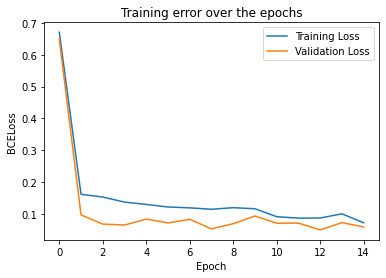

In [ ]:
counter = []
loss_history = []
val_loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(15):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output = net(img0, img1)
        # print(output>0.5)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 500 batches print out the loss
        if i % len(train_dataloader) == 0 :
            print(f"Epoch number {epoch}")
            training_loss = compute_loss(train_dataloader)
            print(f"Training Loss {training_loss}")
            loss_history.append(training_loss)

            iteration_number += 500

            counter.append(epoch)
            # loss_history.append(loss_contrastive.item())
            validation_loss = compute_loss(val_dataloader)
            print(f"Validation Loss {validation_loss}\n")
            val_loss_history.append(validation_loss)
    # # Validation loss
    # val_loss = 0.0
    # val_steps = 0
    # total = 0
    # correct = 0
    # for i, data in enumerate(val_dataloader, 0):
    #     with torch.no_grad():
    #         input0, input1, labels = data
    #         input0, input1, labels = input0.cuda(), input1.cuda(), labels.cuda()

    #         outputs = net(input0, input1)
    #         predicted = outputs>0.5
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()

    #         loss = criterion(outputs, labels)
    #         val_loss += loss.cpu().numpy()
    #         val_steps += 1

    # with tune.checkpoint_dir(epoch) as checkpoint_dir:
    #     path = os.path.join(checkpoint_dir, "checkpoint")
    #     torch.save((net.state_dict(), optimizer.state_dict()), path)

    # tune.report(loss=(val_loss / val_steps), accuracy=correct / total)

show_plot(counter, loss_history, val_loss_history)

In [ ]:
def evaluate(dataloader):
    net.eval()
    tp = tn = fp = fn = 0
    with torch.no_grad():
        for data in dataloader:
            x0, x1, labels = data
            outputs = (net(x0.cuda(), x1.cuda())).cpu()
            pred = outputs[:, 0].numpy() > 0.5
            true = labels[:, 0].numpy() > 0.5
            tp += np.count_nonzero(pred*true)
            fn += np.count_nonzero((1-1*pred)*true)
            fp += np.count_nonzero(pred*(1-true))
            tn += np.count_nonzero((1-1*pred)*(1-true))
    precision = (tp)/(tp+fp)
    recall = tp/(tp+fn)
    print(f"Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {(2*precision*recall)/(precision+recall)}")
    return tp, tn, fp, fn

In [ ]:
evaluate(train_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy: 0.9727800829875519
Precision: 0.9398262128892108
Recall: 0.9302608944954128
F1-Score: 0.9350190908435991


(12979, 51492, 831, 973)

In [ ]:
evaluate(val_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy: 0.9728907480849677
Precision: 0.4593908629441624
Recall: 0.832183908045977
F1-Score: 0.5919869174161897


(362, 17546, 426, 73)

In [ ]:
def make_pred(dataloader):
    net.eval()
    preds = []
    with torch.no_grad():
        for data in dataloader:
            x0, x1, labels = data
            outputs = (net(x0.cuda(), x1.cuda())).cpu()
            pred = outputs[:, 0].numpy() > 0.5
            preds.extend(pred.tolist())
    return preds


def make_dataloader(past, current):
    dataset = SiameseNetworkDataset(past, current, np.zeros((past.shape[0], 2)))
    dataloader = DataLoader(dataset,
                            shuffle=False,
                            num_workers=2,
                            batch_size=64)
    return dataloader


def make_patches_test(arr_2019, arr_2020, arr_deforestation, size=15, stride=3):
    #initialize constants and arrays
    bands, ysize, xsize = arr_2019.shape[0], arr_2019.shape[1], arr_2019.shape[2]
    ypatches = int((ysize-size+stride)//stride)
    xpatches = int((xsize-size+stride)//stride)
    patches_2019 = np.zeros((xpatches*ypatches, bands, size, size))
    patches_2020 = np.zeros((xpatches*ypatches, bands, size, size))
    labels = np.zeros((xpatches*ypatches, 1))
    nan_mask = np.ones(xpatches*ypatches, dtype=bool)
    #read data
    for i in range(0, ysize-size+1, stride):
        for j in range(0, xsize-size+1, stride):
            patches_2019[(i*xpatches+j)//stride] = arr_2019[:, i:i+size, j:j+size]
            patches_2020[(i*xpatches+j)//stride] = arr_2020[:, i:i+size, j:j+size]
            nan_mask[(i*xpatches+j)//stride] = not (np.any(np.isnan(arr_2019[:, i:i+size, j:j+size])) or \
                                                np.any(np.isnan(arr_2020[:, i:i+size, j:j+size])))

    return patches_2019, patches_2020


def create_set(tile, path=folder_path):
    y = int(300*(tile//6))
    x = int(300*(tile%6))
    arr_2019 = get_array(path + f"tiles/tile_2019_{x}_{y}.tif")
    arr_2020 = get_array(path + f"tiles/tile_2020_{x}_{y}.tif")
    arr_deforestation = get_array(path + f"tiles/deforestation_{x}_{y}.tif")
    return make_patches_test(arr_2019, arr_2020, arr_deforestation)

past, current= create_set(0)
pred_test = make_pred(make_dataloader(past, current))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
a = np.array([1.0, 2])
a[0]= np.nan
np.isnan(a.tolist()[0])

True

In [ ]:
def create_diff_image(pred, width, height):
    xpatches = (width-15)//3 + 1
    ypatches = (height-15)//3 + 1
    xpadding = width - 3*xpatches
    ypadding = height - 3*ypatches

    # startx = (xpadding+1)//2
    # starty = (ypadding+1)//2

    arr = np.ones((height, width, 3), dtype=np.uint8) * 255

    for i in range(ypatches):
        for j in range(xpatches):
            ti = starty + 3*i
            tj = startx + 3*j
            if np.isnan(pred[i*xpatches+j]):
                arr[ti:ti+3, tj:tj+3, :] = 0
            else: 
                arr[ti:ti+3, tj:tj+3, 1] = (1-pred[i*xpatches+j])*255
                arr[ti:ti+3, tj:tj+3, 2] = (1-pred[i*xpatches+j])*255
    
    img = Image.fromarray(arr).resize((width, height))

    return np.array(img)


In [ ]:
def create_diff_image(pred, width, height):
    xpatches = (width-15)//3 + 1
    ypatches = (height-15)//3 + 1
    xpadding = width - 3*xpatches
    ypadding = height - 3*ypatches

    # startx = (xpadding+1)//2
    # starty = (ypadding+1)//2

    arr = np.ones((3*ypatches, 3*xpatches, 3), dtype=np.uint8) * 255

    for i in range(ypatches):
        for j in range(xpatches):
            ti = 3*i
            tj = 3*j
            if np.isnan(pred[i*xpatches+j]):
                arr[ti:ti+3, tj:tj+3, :] = 0
            else: 
                arr[ti:ti+3, tj:tj+3, 1] = (1-pred[i*xpatches+j])*255
                arr[ti:ti+3, tj:tj+3, 2] = (1-pred[i*xpatches+j])*255
    
    img = Image.fromarray(arr).resize((width, height))

    return np.array(img)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


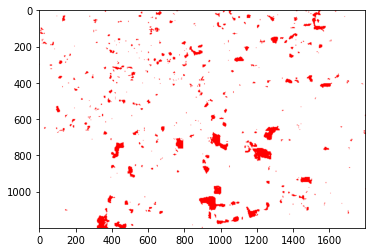

In [ ]:
big_arr = np.zeros((1200, 1800, 3), dtype = np.uint8)
for tile in range(24):
    x = tile%6
    y = tile//6
    past, current = create_set(tile)
    pred_test = make_pred(make_dataloader(past, current))
    arr = create_diff_image(pred_test, 300, 300)
    big_arr[y*300:(y+1)*300, x*300:(x+1)*300, :] = arr
plt.imshow(Image.fromarray(big_arr))

In [ ]:
Image.fromarray(big_arr).save("mehnat.jpg")

In [ ]:
ds = gdal.Open('/content/deforestation_raster_2020.tif')
img_array = np.zeros((3, ds.RasterYSize, ds.RasterXSize), dtype=np.uint8)

img_array[:,:,:] = np.array(ds.GetRasterBand(1).ReadAsArray())/ (20000 if i < 7 else 1) 
# print(img_array.shape)
img_array

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [ ]:
img_array = img_array[:, :1200, :1800]

In [ ]:
img_array.shape

(3, 1200, 1800)

In [ ]:
img_array[0,:,:] = 1
img_array[1,:,:] = 1-img_array[1, :, :]
img_array[2,:,:] = 1-img_array[2, :, :]

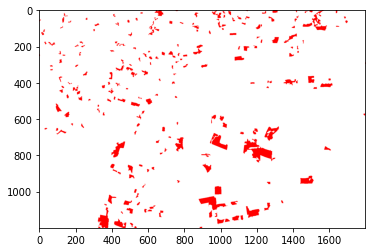

In [ ]:
img = Image.fromarray(np.rollaxis(img_array, 0, 3)*255)
plt.imshow(img)

In [ ]:
img.save('og.jpg')